In [2]:
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')
import numpy as np
import pandas as pd
import xarray as xr

import wandb
import xgboost as xgb
import re

from importlib import reload

# Import Omphalos modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
from analysis import helper as hp

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

random_state = 69
np.random.state = random_state
np.random.seed = random_state

/Users/thomasdodd/opt/anaconda3/envs/omphalos/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Define all the attributes we have varied in .yaml file
attribute_names = ["Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)","Cl-"]

In [4]:
y_norm = 96.2359084
x_norms = [0.0199996777771118,0.0199998101672167,0.019999719657439,0.019999945896381,0.0199997455006281,0.0199994907051103,0.0199990220873342,0.0199997402413945]

In [5]:
# Get all possible pairs of attributes
attribute_pairs_ls = [(a, b) for idx, a in enumerate(attribute_names) for b in attribute_names[idx + 1:]]
print(attribute_pairs_ls)
# Get number of all possible pairs of attributes
attribute_pairs_len = len(attribute_pairs_ls)
print(attribute_pairs_len)

[('Al+++', 'Ca++'), ('Al+++', 'Fe++'), ('Al+++', 'K+'), ('Al+++', 'Na+'), ('Al+++', 'Mg++'), ('Al+++', 'SiO2(aq)'), ('Al+++', 'Cl-'), ('Ca++', 'Fe++'), ('Ca++', 'K+'), ('Ca++', 'Na+'), ('Ca++', 'Mg++'), ('Ca++', 'SiO2(aq)'), ('Ca++', 'Cl-'), ('Fe++', 'K+'), ('Fe++', 'Na+'), ('Fe++', 'Mg++'), ('Fe++', 'SiO2(aq)'), ('Fe++', 'Cl-'), ('K+', 'Na+'), ('K+', 'Mg++'), ('K+', 'SiO2(aq)'), ('K+', 'Cl-'), ('Na+', 'Mg++'), ('Na+', 'SiO2(aq)'), ('Na+', 'Cl-'), ('Mg++', 'SiO2(aq)'), ('Mg++', 'Cl-'), ('SiO2(aq)', 'Cl-')]
28


In [6]:
# Max values for parameters in yaml
yamlvariable_range_upper = 2.0E-2
# Number of samples we'd like to get the model to predict on
samples = 100
# The controlled values in the base .in file
incontrolled_val = 1.00E-10

In [7]:
# Load the XGBoost model trained earlier
bst = xgb.Booster()
bst.load_model(fname='bfm_XGBModel_5-5_Epo-3000.json')

In [8]:
# The (ab)normalization functions
def NormalizeData(data, upper):
    return data / upper
def AbNormalizeData(data, upper):
    return data * upper
def ScaleData(data, scale_factor):
    return data * scale_factor

In [9]:
def xyz_mesh_getter_narrowed(upper, samples, attrib_names, attrib_pair, var_controlled, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms):
    x_attrib_name = attrib_pair[0]
    y_attrib_name = attrib_pair[1]

    x_attrib_name_upper = 0
    x_attrib_name_lower = 0

    y_attrib_name_upper = 0
    y_attrib_name_lower = 0

    for _,__,___ in zip(attrib_names, attribute_names_uppers, attribute_names_lowers):
        if x_attrib_name == _:
            x_attrib_name_upper = __
            x_attrib_name_lower = ___
        elif y_attrib_name == _:
            y_attrib_name_upper = __
            y_attrib_name_lower = ___
    
    x_normalising_value = 0
    y_normalising_value = 0

    for _,__ in zip(attrib_names, x_norms):
        if x_attrib_name == _:
            x_normalising_value = __
        elif y_attrib_name == _:
            y_normalising_value = __

    xpred = np.linspace(x_attrib_name_lower, x_attrib_name_upper, samples)
    xpred = xpred.reshape(-1,1)
    xpred_norm = NormalizeData(xpred, x_normalising_value)
    xpred_scaled = ScaleData(xpred, 1000)

    ypred = np.linspace(y_attrib_name_lower, y_attrib_name_upper, samples)
    ypred = ypred.reshape(-1,1)
    ypred_norm = NormalizeData(ypred, y_normalising_value)
    ypred_scaled = ScaleData(xpred, 1000)

    X,Y = np.meshgrid(xpred,ypred)
    X_norm,Y_norm = np.meshgrid(xpred_norm,ypred_norm)
    X_scaled, Y_scaled = np.meshgrid(xpred_scaled,ypred_scaled)

    Z = np.empty_like(X)
    Z_norm = np.empty_like(X)

    row = 0
    for X_row_arr,Y_row_arr in zip(X_norm,Y_norm):
        column = 0
        for X_scalar,Y_scalar in zip(X_row_arr,Y_row_arr):
            XYScalars = [X_scalar,Y_scalar]
            end_attrib_list = []

            for _ in attrib_names:
                if x_attrib_name == _:
                    end_attrib_list.append(XYScalars[0])
                elif y_attrib_name == _:
                    end_attrib_list.append(XYScalars[1])
                else:
                    end_attrib_list.append(var_controlled)

            zpred_norm = bst.predict(xgb.DMatrix(np.array([end_attrib_list])))
            zpred = AbNormalizeData(zpred_norm, y_norm)
            Z[row,column] = zpred
            Z_norm[row,column] = zpred_norm
            column += 1
        row += 1
    return X_scaled, Y_scaled, Z

In [14]:
attribute_names_uppers = [1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2,1.6E-2]
# attribute_names_uppers = [2.0E-2,2.0E-2,2.0E-2,2.0E-2,2.0E-2,2.0E-2,2.0E-2,2.0E-2]
attribute_names_lowers = [0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2,0.2E-2]

Text(0.5, 0, 'Carbonates (%)')

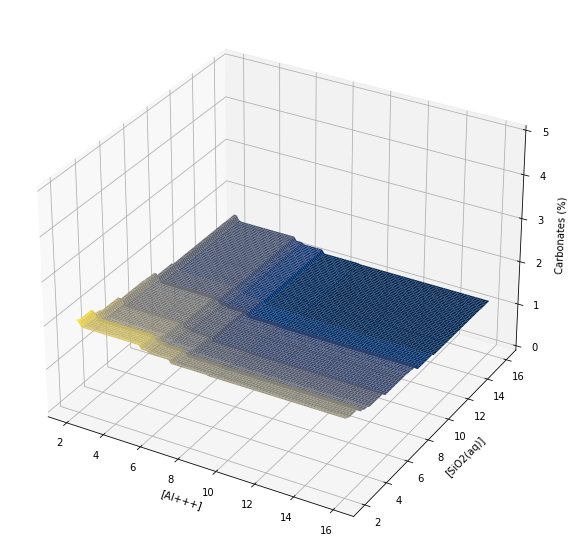

In [15]:
# Set the attribute pair
attribute_pair = attribute_pairs_ls[5]
# Assign the two string items in the pair to a variable each
x_attrib_name = attribute_pair[0]
y_attrib_name = attribute_pair[1]
# Generate a mesh dataset in the X,Y, and Z axes
X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(30)
ax = fig.add_subplot(1,2,1,projection='3d')
ax.set_zlim(0, 5)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
ax.set_xlabel(f'[{x_attrib_name}]')
ax.set_ylabel(f'[{y_attrib_name}]')
ax.set_zlabel('Carbonates (%)')

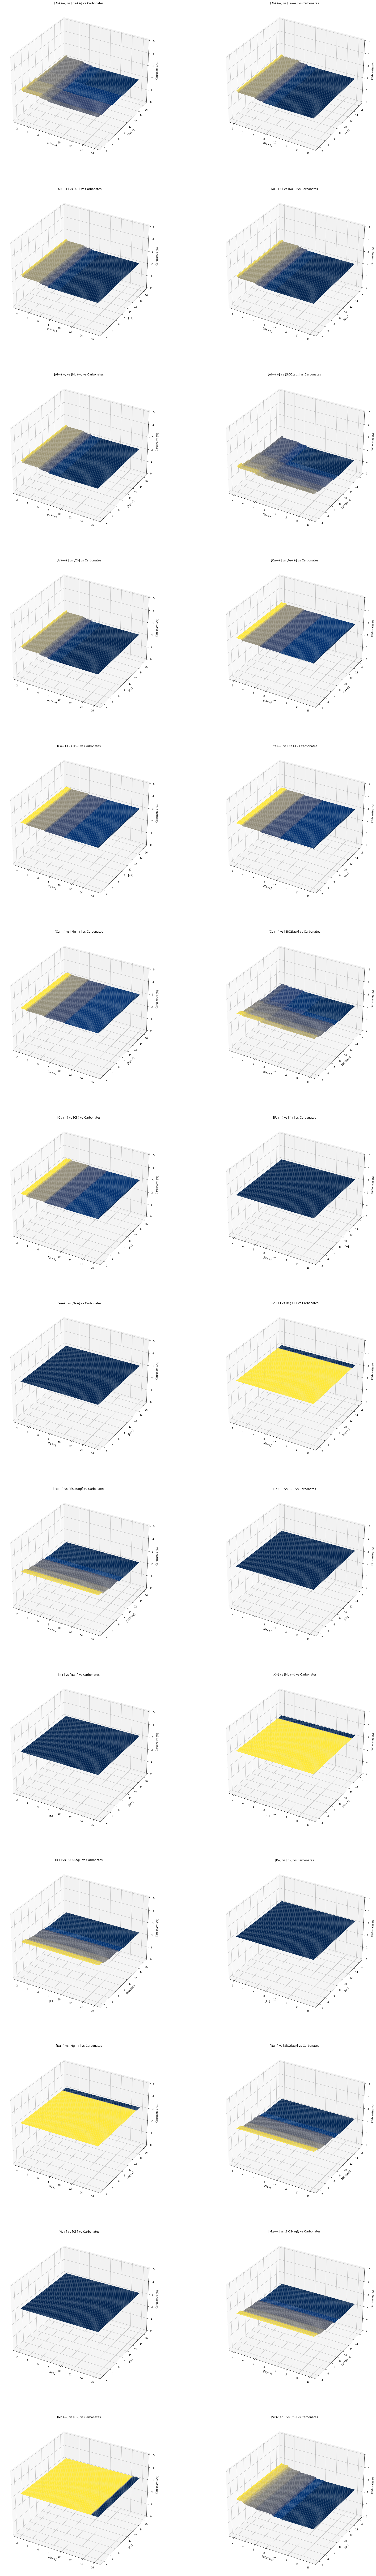

In [26]:
fig = plt.figure(figsize=(30,200))
fig.tight_layout(h_pad=-75, w_pad=10, pad=5)

ax1 = fig.add_subplot(14,2,1, projection='3d')
ax2 = fig.add_subplot(14,2,2, projection='3d')
ax3 = fig.add_subplot(14,2,3, projection='3d')
ax4 = fig.add_subplot(14,2,4, projection='3d')
ax5 = fig.add_subplot(14,2,5, projection='3d')
ax6 = fig.add_subplot(14,2,6, projection='3d')
ax7 = fig.add_subplot(14,2,7, projection='3d')
ax8 = fig.add_subplot(14,2,8, projection='3d')
ax9 = fig.add_subplot(14,2,9, projection='3d')
ax10 = fig.add_subplot(14,2,10, projection='3d')
ax11 = fig.add_subplot(14,2,11, projection='3d')
ax12 = fig.add_subplot(14,2,12, projection='3d')
ax13 = fig.add_subplot(14,2,13, projection='3d')
ax14 = fig.add_subplot(14,2,14, projection='3d')
ax15 = fig.add_subplot(14,2,15, projection='3d')
ax16 = fig.add_subplot(14,2,16, projection='3d')
ax17 = fig.add_subplot(14,2,17, projection='3d')
ax18 = fig.add_subplot(14,2,18, projection='3d')
ax19 = fig.add_subplot(14,2,19, projection='3d')
ax20 = fig.add_subplot(14,2,20, projection='3d')
ax21 = fig.add_subplot(14,2,21, projection='3d')
ax22 = fig.add_subplot(14,2,22, projection='3d')
ax23 = fig.add_subplot(14,2,23, projection='3d')
ax24 = fig.add_subplot(14,2,24, projection='3d')
ax25 = fig.add_subplot(14,2,25, projection='3d')
ax26 = fig.add_subplot(14,2,26, projection='3d')
ax27 = fig.add_subplot(14,2,27, projection='3d')
ax28 = fig.add_subplot(14,2,28, projection='3d')

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24,ax25,ax26,ax27,ax28]

for axe,attrib_pair in zip(axes,attribute_pairs_ls):
    attribute_pair = attrib_pair
    x_attrib_name = attrib_pair[0]
    y_attrib_name = attrib_pair[1]
    X, Y, Z = xyz_mesh_getter_narrowed(yamlvariable_range_upper, samples, attribute_names, attribute_pair, incontrolled_val, y_norm, attribute_names_uppers, attribute_names_lowers, x_norms)
    axe.set_title(f"[{x_attrib_name}] vs [{y_attrib_name}] vs Carbonates")
    axe.set_zlim(0,5)
    axe.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cividis', edgecolor='none')
    axe.set_xlabel(f'[{x_attrib_name}]')
    axe.set_ylabel(f'[{y_attrib_name}]')
    axe.set_zlabel('Carbonates (%)')